In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.utils import resample
from utils import load_checkpoint

In [2]:
from model import AttentionModel
from dataset import TextDataset

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [4]:
data_path = '../data'
model_path = '../model'

In [5]:
df_ = pd.read_csv(os.path.join(r'E:\NLP\Vietnamese-Text-Classification-master\data\labeled_data.csv'))

In [6]:
question = df_[df_['label']!=0]
question['label'] = [item-1 for item in list(question['label'])]
question

C:\Users\nguye\AppData\Local\Temp\ipykernel_28524\288649093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question['label'] = [item-1 for item in list(question['label'])]


,label,content
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...
2,0,cho em hỏi chương trình chất lượng cao ở bách ...
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...
8,1,cho em hỏi ngành khoa học máy tính có những hì...
...,...,...
428,2,cho em hỏi về ngành kỹ thuật hoá học và cơ hội...
429,2,cho em xin giới thiệu về ngành kỹ thuật robot ạ
430,2,ngành khoa học máy tính sau này ra làm công vi...
431,2,em muốn học tự động hoá thì tương lai sẽ có ng...


In [7]:
class_0 = question[question['label']==0]
class_0_upsampled = resample(class_0,random_state=42,n_samples=90-len(class_0),replace=True)
question_upsampled = pd.concat([question, class_0_upsampled])

In [8]:
question_upsampled['label'].value_counts()

2    148
1    122
0     90
Name: label, dtype: int64

In [9]:
question  = question_upsampled

In [10]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

In [11]:
print(question)

     label                                            content  length  \
0        0  thầy cho em hỏi nếu mình đã trúng tuyển chương...     159   
2        0  cho em hỏi chương trình chất lượng cao ở bách ...     106   
3        0  cho em hỏi nếu em đã trúng tuyển chương trình ...     148   
5        1  cho em hỏi chỉ tiêu ngành khoa học máy tính nă...     108   
8        1  cho em hỏi ngành khoa học máy tính có những hì...      70   
..     ...                                                ...     ...   
118      0  cho em hỏi là học xây dựng trường mình xong th...      87   
262      0           chương trình việt pháp học phí thế nào ạ      40   
2        0  cho em hỏi chương trình chất lượng cao ở bách ...     106   
145      0  dạ cho em hỏi ngành hóa liên kết quốc tế với t...      57   
182      0  cho em hỏi thời gian pre uni học tiếng anh đối...     109   

     num_word  
0          33  
2          24  
3          31  
5          25  
8          16  
..        ...  
118        

In [12]:
np.mean(question['num_word'])

17.336111111111112

(array([36., 81., 77., 61., 39., 30., 25.,  5.,  3.,  3.]),
 array([ 6. ,  9.6, 13.2, 16.8, 20.4, 24. , 27.6, 31.2, 34.8, 38.4, 42. ]),
 <BarContainer object of 10 artists>)

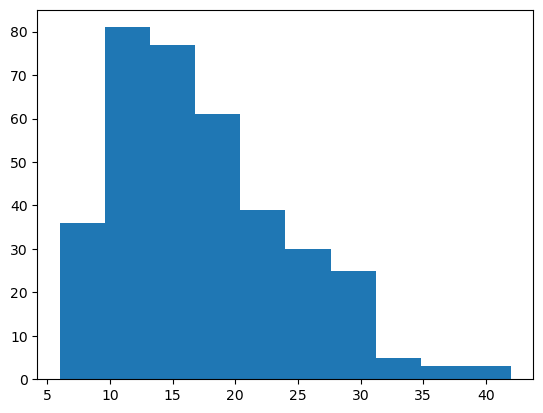

In [13]:
plt.hist(list(question['num_word']), bins = 10)

In [14]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [15]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['content']))

In [16]:
print(counts.items())

dict_items([('thầy', 70), ('cho', 182), ('em', 191), ('hỏi', 174), ('nếu', 13), ('mình', 33), ('đã', 4), ('trúng_tuyển', 4), ('chương_trình', 78), ('đại_trà', 19), ('thì', 61), ('có_thể', 22), ('đổi', 1), ('sang', 8), ('chất_lượng', 56), ('cao', 61), ('tiếng', 20), ('anh', 22), ('hoặc', 4), ('tiên_tiến', 4), ('được', 57), ('không', 138), ('ạ', 329), ('ở', 22), ('bách_khoa', 13), ('có', 140), ('học', 73), ('hoàn_toàn', 4), ('trên', 3), ('cơ_sở', 2), ('lý', 2), ('thường', 7), ('kiệt', 2), ('chuyển', 6), ('chỉ_tiêu', 20), ('ngành', 184), ('khoa_học', 35), ('máy_tính', 43), ('năm', 28), ('nay', 17), ('bao_nhiêu', 31), ('và', 60), ('giới_thiệu', 3), ('về', 79), ('với', 31), ('những', 30), ('hình_thức', 3), ('tuyển_sinh', 12), ('nào', 46), ('sau', 10), ('khi', 25), ('xong', 4), ('4', 3), ('kỹ_sư', 20), ('việt', 20), ('nhật', 12), ('trường', 52), ('sẽ', 22), ('qua', 3), ('tiếp_tục', 1), ('hay', 21), ('làm_việc', 4), ('giảng_dạy', 3), ('bằng', 15), ('sao', 17), ('kỹ', 2), ('thật', 2), ('điện',

In [17]:
from collections import Counter
with open("file.txt", 'w', encoding='utf-8') as f:
    for key, value in counts.items():
        f.write(f"{key}: {value},")

In [18]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 535
num_words after: 323


In [19]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [20]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [21]:
print(words)

['', 'UNK', 'thầy', 'cho', 'em', 'hỏi', 'nếu', 'mình', 'đã', 'trúng_tuyển', 'chương_trình', 'đại_trà', 'thì', 'có_thể', 'sang', 'chất_lượng', 'cao', 'tiếng', 'anh', 'hoặc', 'tiên_tiến', 'được', 'không', 'ạ', 'ở', 'bách_khoa', 'có', 'học', 'hoàn_toàn', 'trên', 'cơ_sở', 'lý', 'thường', 'kiệt', 'chuyển', 'chỉ_tiêu', 'ngành', 'khoa_học', 'máy_tính', 'năm', 'nay', 'bao_nhiêu', 'và', 'giới_thiệu', 'về', 'với', 'những', 'hình_thức', 'tuyển_sinh', 'nào', 'sau', 'khi', 'xong', '4', 'kỹ_sư', 'việt', 'nhật', 'trường', 'sẽ', 'qua', 'hay', 'làm_việc', 'giảng_dạy', 'bằng', 'sao', 'kỹ', 'thật', 'điện', 'điện_tử', 'cơ_hội', 'việc_làm', 'ra', 'kỹ_thuật', 'hàng', 'là', 'quản_lí', 'công_nghiệp', 'nó', 'triển_vọng', 'như', 'thế_nào', 'thưa', 'các', 'muốn', 'rồi', 'cần', 'phải', 'thi', 'ielts', 'vào', 'e', 'tự_động', 'hóa', 'cơ_điện_tử', 'khác', 'nhau', 'chỗ', 'nam', 'tốt', 'hơn', 'vật_liệu', 'nhiều', 'dễ', 'xin', 'việc', 'nên', 'pháp', 'bên', 'mới', 'điểm_chuẩn', 'logistics', 'hàng_không', 'của', 'làm', '

In [22]:
N = 22
question['encoded'] = question['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

,label,content,length,num_word,encoded
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...,159,33,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 1..."
2,0,cho em hỏi chương trình chất lượng cao ở bách ...,106,24,"[[3, 4, 5, 10, 15, 16, 24, 25, 26, 21, 27, 28,..."
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...,148,31,"[[3, 4, 5, 6, 4, 8, 9, 10, 11, 12, 4, 13, 34, ..."
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...,108,25,"[[3, 4, 5, 35, 36, 37, 38, 39, 40, 41, 42, 43,..."
8,1,cho em hỏi ngành khoa học máy tính có những hì...,70,16,"[[3, 4, 5, 36, 37, 38, 26, 46, 47, 48, 49, 23,..."


In [23]:
column_to_check = 'encoded'
if isinstance(question[column_to_check].values, np.ndarray):
    print(f"Cột '{column_to_check}' là một mảng NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải là một mảng NumPy.")

Cột 'encoded' là một mảng NumPy.


In [24]:
column_name = 'encoded'
numpy_array = question[column_name].values
shape_column = numpy_array.shape
shape_column

(360,)

In [25]:
column_to_check = 'encoded'
numpy_array = question[column_to_check].values
dtype_column = numpy_array.dtype
print(dtype_column)

if dtype_column == 'object':
    print(f"Cột '{column_to_check}' có dạng chuỗi (string) trong NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải dạng chuỗi (string) trong NumPy.")

object
Cột 'encoded' có dạng chuỗi (string) trong NumPy.


In [26]:
X = list(question['encoded'])
y = list(question['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=42)

In [27]:
print(X[:1])

[array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  1, 14, 10, 15,
        16, 17, 18, 19, 10, 20]])]


In [28]:
print(y)

[0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 

In [29]:
len(X_train),len(X_valid)

(270, 90)

In [30]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train).tolist(),y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

E:\Anaconda\envs\word_spelling_autocorrect\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0, 1, 2], y=[2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2] as keyword args. From version 0.25 passing these as pos

tensor([1.3636, 0.9091, 0.8571])

In [31]:
train_ds = TextDataset(X_train, y_train)
print(train_ds)
valid_ds = TextDataset(X_valid, y_valid)

In [32]:
batch_size = 30
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [33]:
model = AttentionModel(
                    batch_size=batch_size, 
                    output_size=class_weights.shape[0], 
                    hidden_size=128, 
                    vocab_size=vocab_size, 
                    embedding_length=400
                    )

In [34]:
model = model.train()
model.cpu()

AttentionModel(
  (word_embeddings): Embedding(325, 400)
  (lstm): LSTM(400, 128)
  (label): Linear(in_features=128, out_features=3, bias=True)
)

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [36]:
def train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    list_pred = []
    for x, y in train_dl:
        y = y.type(torch.int64)
        x = x.long()

        y_pred = model(x)

        optimizer.zero_grad()


        loss = criterion(y_pred,y)
        
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        list_pred.append(y_pred.argmax())
    return epoch_loss / len(train_dl)

In [37]:
def evaluate_one_epoch(model, valid_dl,criterion,writer,epoch):
    model.eval()
    epoch_acc = 0
    epoch_loss = 0
    list_true = []
    list_pred = []
    with torch.no_grad():
        for x, y in valid_dl:
            y = y.type(torch.int64)
            x = x.long()
            y_hat = model(x)
#             acc = binary_accuracy(y_hat,y)
            loss = criterion(y_hat,y)
            writer.add_scalar("Loss/valid", loss, epoch)
            epoch_loss += loss.item()

    return epoch_loss/len(valid_dl)

In [38]:

loss=[]
acc=[]
val_loss=[]
acc_max = 0

valid_loss_min = 1.

for epoch in range(30):
    
    train_loss = train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch)
    valid_loss = evaluate_one_epoch(model, val_dl,criterion,writer,epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    if valid_loss < valid_loss_min:
        valis_loss_min = valid_loss
        checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
#         valis_loss_save = str(valis_loss_min).replace('.','_')[:10]
        torch.save(checkpoint, os.path.join(model_path,'checkpoint_{}.pth'.format(valis_loss_min)))

    exp_lr_scheduler.step()
    
writer.flush()
writer.close()

Epoch-0 lr: 0.001
	Train Loss: 1.135 | Valid Loss: 1.161
Epoch-1 lr: 0.001
	Train Loss: 1.087 | Valid Loss: 1.074
Epoch-2 lr: 0.001
	Train Loss: 1.055 | Valid Loss: 1.061
Epoch-3 lr: 0.001
	Train Loss: 0.992 | Valid Loss: 1.023
Epoch-4 lr: 0.001
	Train Loss: 0.880 | Valid Loss: 0.913


RuntimeError: File ../model\checkpoint_0.9130431811014811.pth cannot be opened.

In [ ]:
load_model = load_checkpoint(os.path.join(model_path,'checkpoint_0.38374345004558563.pth'))

In [ ]:
from pytorch_model_summary import summary
print(summary(load_model, torch.zeros([30,22]).long(), show_input=True))

In [ ]:
load_model

In [ ]:
print(classification_report(list_pred,list_true))

In [ ]:
confusion_matrix(list_pred,list_true)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(list_pred,list_true),
                      normalize    = True,
                      target_names = ['type_edu', 'case', 'career'],
                      title        = "Confusion Matrix, Bi-LSTM+Attention")

In [ ]:
np.average(f1_score(list_true, list_pred, average=None))

# Test

In [ ]:
# load_model

In [ ]:
# filename = os.path.join(model_path,'model_intent.pth')
# joblib.dump(load_model, filename)
# # with open('vectorizer.pickle', 'wb') as handle:
# #     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# import requests
# url = 'https://api-intent.herokuapp.com/predict'
# pred = requests.post(url,json={'message':'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ'})
# print(pred.json())


In [ ]:
# for x,y in val_dl:
#     print(x.shape)

In [ ]:
# vocab2index

In [ ]:
torch.save(vocab2index,os.path.join(model_path,'vocab_12jul.pth'))

In [ ]:
vocab2index = torch.load(os.path.join(model_path,'vocab_12jul.pth'))

In [ ]:
N

In [ ]:
pad_enc = torch.zeros([29,22])
# pad_enc.shape

In [ ]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,N))
test_enc

In [ ]:
test_enc_pad = torch.cat([test_enc,pad_enc])
test_enc_pad.shape

In [ ]:

preds = load_model(test_enc_pad.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds[0])
pred_label = prop_preds.argmax().item()
pred_label